In [2]:
import numpy as np
from astropy.io import ascii


# Read UHECR
filename_e = '../data/Auger/events_a8_lb.dat'
events_a8 = ascii.read(filename_e)

# Read Gxs
filename_g = '../data/VLS/2MRSxWISE_VLS.txt'
data = ascii.read(filename_g)



###### Chequeando que las dos muestras tengan el mismo rango de posiciones

In [3]:
print('Gxs DEC range:%5.2fdeg - %5.2fdeg' % (data['_DEJ2000'].min(),data['_DEJ2000'].max()))
print('Gxs RA range:%5.2fdeg - %5.2fdeg' % (data['_RAJ2000'].min(),data['_RAJ2000'].max()))

print('UHECR DEC range:%5.2fdeg - %5.2fdeg' % (events_a8['dec'].min(),events_a8['dec'].max()))
print('UHECR RA range:%5.2fdeg - %5.2fdeg' % (events_a8['RA'].min(),events_a8['RA'].max()))


Gxs DEC range:-87.77deg - 44.95deg
Gxs RA range: 0.81deg - 359.86deg
UHECR DEC range:-89.90deg - 44.70deg
UHECR RA range: 0.00deg - 360.00deg


In [4]:
import treecorr
import numpy as np

gcat = treecorr.Catalog(filename_g, ra_col='_RAJ2000', dec_col='_DEJ2000', ra_units='deg', dec_units='deg')
ecat = treecorr.Catalog(filename_e, ra_col='RA', dec_col='dec', ra_units='deg', dec_units='deg')

print('ra range = %f .. %f' % (gcat.ra.min(), gcat.ra.max()))
print('dec range = %f .. %f' % (gcat.dec.min(), gcat.dec.max()))

ra range = 0.014177 .. 6.280677
dec range = -1.531915 .. 0.784610


In [5]:

ra_min = np.min(gcat.ra)
ra_max = np.max(gcat.ra)
dec_min = np.min(gcat.dec)
dec_max = np.max(gcat.dec)
print('ra range = %f .. %f' % (ra_min, ra_max))
print('dec range = %f .. %f' % (dec_min, dec_max))

rand_ra = np.random.uniform(ra_min, ra_max, gcat.ntot*10)
rand_sindec = np.random.uniform(np.sin(dec_min), np.sin(dec_max), gcat.ntot*10)
rand_dec = np.arcsin(rand_sindec)
print('ra range = %f .. %f' % (rand_ra.min(), rand_ra.max()))
print('dec range = %f .. %f' % (rand_dec.min(), rand_dec.max()))

ra range = 0.014177 .. 6.280677
dec range = -1.531915 .. 0.784610
ra range = 0.014208 .. 6.280399
dec range = -1.531358 .. 0.784582


#### Plottear todo, just in case

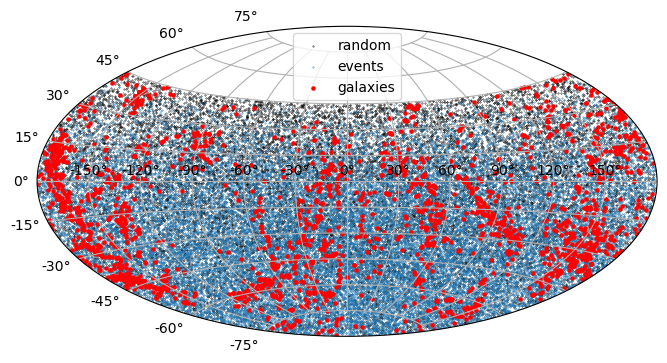

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u

gxs = SkyCoord(data['_RAJ2000'],data['_DEJ2000'],frame='icrs',unit='degree')
eve = SkyCoord(events_a8['RA'],events_a8['dec'],frame='icrs',unit='degree')
ran = SkyCoord(rand_ra,rand_dec,frame='icrs',unit='rad')

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="aitoff")
ax.scatter(ran.ra.wrap_at(180*u.degree).to(u.rad),ran.dec.to(u.rad),s=.1,c='k',label='random')
ax.scatter(eve.ra.wrap_at(180*u.degree).to(u.rad),eve.dec.to(u.rad),s=.1,label='events')
ax.scatter(gxs.ra.wrap_at(180*u.degree).to(u.rad),gxs.dec.to(u.rad),s=5,c='r',label='galaxies')
ax.legend()
ax.grid(True)
plt.show()

#### Probar calcular la autocorrelacion

In [11]:
#data = treecorr.Catalog(data_file, config)
#rand = treecorr.Catalog(rand_file, config)

minsep = 10.
maxsep = 90.
nbins = 15

dd = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree')
dr = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree')

rcat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, ra_units='radians', dec_units='radians')
rr = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree')

rr.process(rcat)
dd.process(gcat)
dr.process(gcat,rcat)

xi, varxi = dd.calculateXi(rr=rr,dr=dr)

[0.01260787 0.01095691 0.00948843 0.00821309 0.00711811 0.00617483
 0.00535008 0.00464768 0.0040393  0.00350791 0.00305627 0.00266264
 0.00232618 0.00203022 0.00176662]


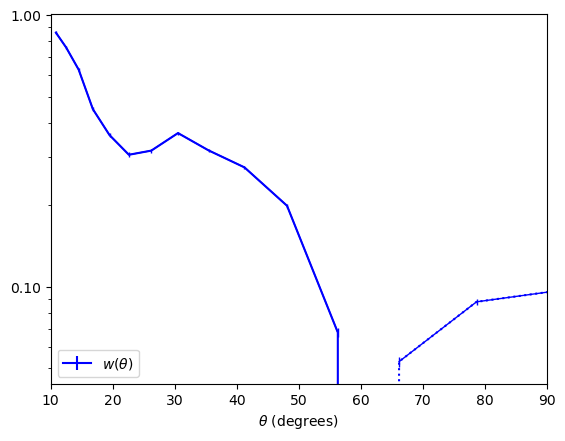

In [34]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as mtick

fig, ax = plt.subplots()

sig = np.sqrt(varxi)
print(sig)
r = np.exp(dd.meanlogr)

ax.plot(r, xi, color='blue')
ax.plot(r, -xi, color='blue', ls=':')
ax.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=1)
ax.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=1)
leg = ax.errorbar(-r, xi, yerr=sig, color='blue')

#ax.set_xscale('log')
ax.set_yscale('log', nonpositive='clip')
ax.set_xlabel(r'$\theta$ (degrees)')

ax.legend([leg], [r'$w(\theta)$'], loc='lower left')
ax.set_xlim([10,90])

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
#ax.xaxis.set_minor_formatter(mtick.FormatStrFormatter('%.0f'))

#plt.axis

plt.show()

#### Probar la Cross-Corr

In [35]:
minsep = 10.
maxsep = 90.
nbins = 15

rcat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, ra_units='radians', dec_units='radians')


dd = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree')
dr = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree')
rr = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree')
rd = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree')

rr.process(rcat)
dd.process(gcat,ecat)
dr.process(gcat,rcat)
rd.process(rcat,gcat)

xi, varxi = dd.calculateXi(rr=rr,dr=dr,rd=rd)

[0.00877954 0.00762988 0.0066073  0.00571922 0.00495672 0.00429986
 0.00372555 0.00323643 0.00281278 0.00244274 0.00212825 0.00185414
 0.00161984 0.00141375 0.00123019]


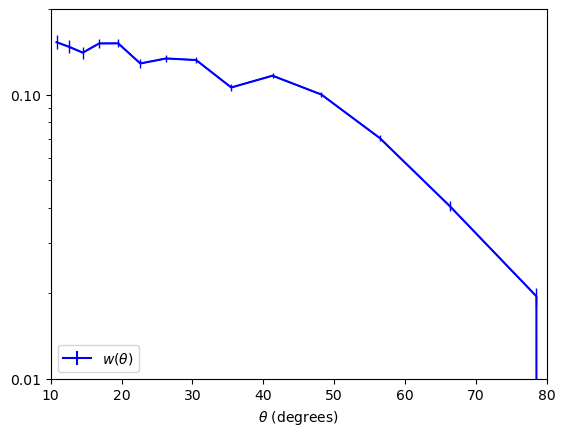

In [41]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()

sig = np.sqrt(varxi)
print(sig)
r = np.exp(dd.meanlogr)

ax.plot(r, xi, color='blue')
ax.plot(r, -xi, color='blue', ls=':')
ax.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=1)
ax.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=1)
leg = ax.errorbar(-r, xi, yerr=sig, color='blue')

#ax.set_xscale('log')
ax.set_yscale('log', nonpositive='clip')
ax.set_xlabel(r'$\theta$ (degrees)')

ax.legend([leg], [r'$w(\theta)$'], loc='lower left')
ax.set_xlim([10,80])
ax.set_ylim([.01,.2])

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
#ax.xaxis.set_minor_formatter(mtick.FormatStrFormatter('%.0f'))

#plt.axis

plt.show()

#### Probar Cross con Bright/Faint

In [5]:
from astropy.io import ascii
import numpy as np

# Read UHECR
filename_e = '../data/Auger/events_a8_lb.dat'
#events_a8 = ascii.read(filename_e)

# Read Gxs
filename_g = '../data/VLS/2MRSxWISE_VLS.txt'
data = ascii.read(filename_g)

# Bright/Faint
data_bright = data[(data['K_abs']<-23.2)&(data['K_abs']>-26.)]
data_faint = data[(data['K_abs']>-23.2)&(data['K_abs']<-22.)]

# Random Catalogue

ra_min = np.min(data_bright['_RAJ2000'].min())
ra_max = np.max(data_bright['_RAJ2000'].max())
dec_min = np.min(data_bright['_DEJ2000'].min())
dec_max = np.max(data_bright['_DEJ2000'].max())

rand_ra = np.random.uniform(ra_min, ra_max, len(data_bright)*10)
rand_sindec = np.random.uniform(np.sin(dec_min), np.sin(dec_max), len(data_bright)*10)
rand_dec = np.arcsin(rand_sindec)


In [14]:

# TreeCorr Catalogues
import treecorr

gcat = treecorr.Catalog(ra=data_bright['_RAJ2000'], dec=data_bright['_DEJ2000'],ra_units='deg', dec_units='deg')
ecat = treecorr.Catalog(filename_e, ra_col='RA', dec_col='dec', ra_units='deg', dec_units='deg')
rcat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, ra_units='radians', dec_units='radians')

minsep = 10.
maxsep = 90.
nbins = 15

dd = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree')
dr = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree')
rr = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree')
rd = treecorr.NNCorrelation(min_sep=minsep, max_sep=maxsep, nbins=nbins, sep_units='degree')

rr.process(rcat)
dd.process(gcat,ecat)
dr.process(gcat,rcat)
rd.process(rcat,ecat)

xi, varxi = dd.calculateXi(rr=rr,dr=dr,rd=rd)

[0.00641091 0.00576069 0.00519786 0.0047481  0.00442213 0.00421867
 0.00399703 0.00372532 0.00344207 0.00314494 0.00285843 0.00253168
 0.00214084 0.00168265 0.00173725]


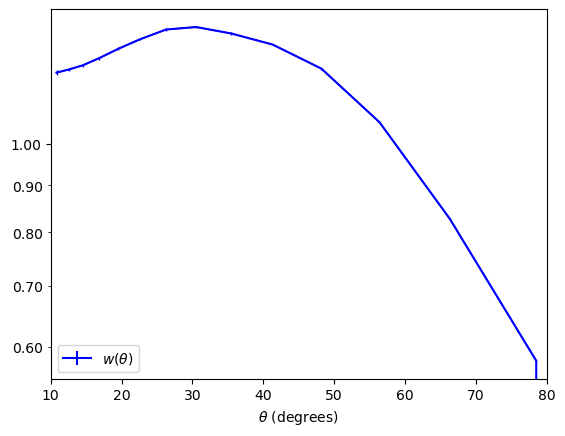

In [15]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()

sig = np.sqrt(varxi)
print(sig)
r = np.exp(dd.meanlogr)

ax.plot(r, xi, color='blue')
#ax.plot(r, -xi, color='blue', ls=':')
ax.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=1)
#ax.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=1)
leg = ax.errorbar(-r, xi, yerr=sig, color='blue')

#ax.set_xscale('log')
ax.set_yscale('log', nonpositive='clip')
ax.set_xlabel(r'$\theta$ (degrees)')

ax.legend([leg], [r'$w(\theta)$'], loc='lower left')
ax.set_xlim([10,80])
#ax.set_ylim([.01,.2])

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_minor_formatter(FormatStrFormatter('%.2f'))

#ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
#ax.xaxis.set_minor_formatter(mtick.FormatStrFormatter('%.0f'))

#plt.axis

plt.show()